In [1]:
import pandas as pd

df_woe = pd.read_csv('../data/processed/df_woe.csv')

In [2]:
from sklearn.model_selection import train_test_split

X = df_woe.drop(columns=['default'])
y = df_woe['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")
print("Default rate in train:", y_train.mean())
print("Default rate in test:", y_test.mean())

Train size: 3117 | Test size: 1336
Default rate in train: 0.18318896374719282
Default rate in test: 0.18338323353293412


In [3]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

coef_table = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': clf.coef_[0]})
print(coef_table.sort_values(by='Coefficient', ascending=False))

                     Feature  Coefficient
2                   term_woe     0.771039
5   mo_sin_old_rev_tl_op_woe     0.619137
6                    dti_woe     0.593177
3               mort_acc_woe     0.591162
9         total_bc_limit_woe     0.481594
4            avg_cur_bal_woe     0.477466
0               int_rate_woe     0.469451
8         bc_open_to_buy_woe     0.399640
10  acc_open_past_24mths_woe     0.377747
1        fico_range_high_woe     0.302479
7            open_rv_24m_woe     0.237422


In [4]:
y_pred_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

In [5]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")

AUC: 0.762


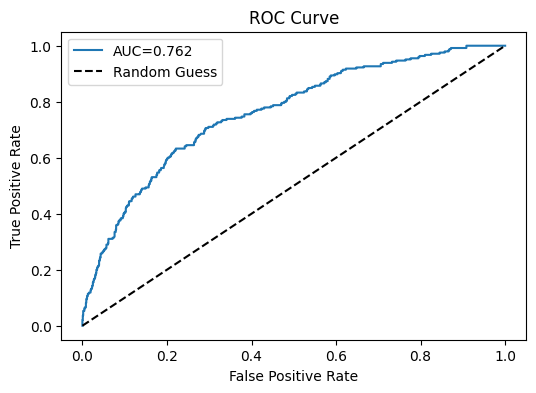

In [6]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[1061   30]
 [ 205   40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1091
           1       0.57      0.16      0.25       245

    accuracy                           0.82      1336
   macro avg       0.70      0.57      0.58      1336
weighted avg       0.79      0.82      0.78      1336



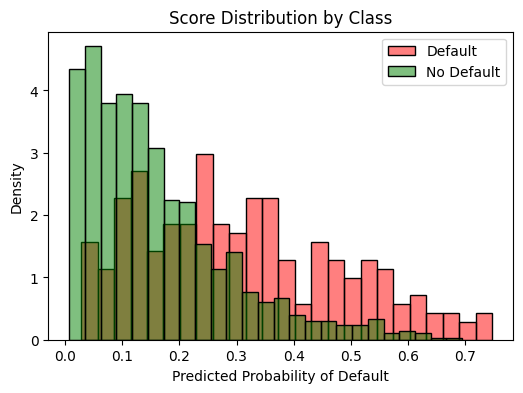

In [9]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(y_pred_proba[y_test==1], color='red', label='Default', stat='density', bins=25, alpha=0.5)
sns.histplot(y_pred_proba[y_test==0], color='green', label='No Default', stat='density', bins=25, alpha=0.5)
plt.xlabel("Predicted Probability of Default")
plt.title("Score Distribution by Class")
plt.legend()
plt.show()

In [10]:
clf_balanced = LogisticRegression(
    solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced'
)
clf_balanced.fit(X_train, y_train)

y_pred_proba_bal = clf_balanced.predict_proba(X_test)[:, 1]
y_pred_bal = clf_balanced.predict(X_test)

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

auc_bal = roc_auc_score(y_test, y_pred_proba_bal)
print(f"AUC (balanced): {auc_bal:.3f}")

print("Confusion Matrix (balanced):")
print(confusion_matrix(y_test, y_pred_bal))

print("Classification Report (balanced):")
print(classification_report(y_test, y_pred_bal))

AUC (balanced): 0.763
Confusion Matrix (balanced):
[[735 356]
 [ 70 175]]
Classification Report (balanced):
              precision    recall  f1-score   support

           0       0.91      0.67      0.78      1091
           1       0.33      0.71      0.45       245

    accuracy                           0.68      1336
   macro avg       0.62      0.69      0.61      1336
weighted avg       0.81      0.68      0.72      1336



In [11]:
# Try a lower threshold to catch more defaults
threshold = 0.25
y_pred_bal_adj = (y_pred_proba_bal >= threshold).astype(int)
print("Confusion Matrix with threshold 0.25 (balanced):")
print(confusion_matrix(y_test, y_pred_bal_adj))
print(classification_report(y_test, y_pred_bal_adj))

Confusion Matrix with threshold 0.25 (balanced):
[[298 793]
 [ 15 230]]
              precision    recall  f1-score   support

           0       0.95      0.27      0.42      1091
           1       0.22      0.94      0.36       245

    accuracy                           0.40      1336
   macro avg       0.59      0.61      0.39      1336
weighted avg       0.82      0.40      0.41      1336



In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

clf_smote = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
clf_smote.fit(X_train_sm, y_train_sm)

y_pred_proba_sm = clf_smote.predict_proba(X_test)[:, 1]
y_pred_sm = clf_smote.predict(X_test)

auc_sm = roc_auc_score(y_test, y_pred_proba_sm)
print(f"AUC (SMOTE): {auc_sm:.3f}")
print("Confusion Matrix (SMOTE):")
print(confusion_matrix(y_test, y_pred_sm))
print(classification_report(y_test, y_pred_sm))

AUC (SMOTE): 0.759
Confusion Matrix (SMOTE):
[[748 343]
 [ 72 173]]
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1091
           1       0.34      0.71      0.45       245

    accuracy                           0.69      1336
   macro avg       0.62      0.70      0.62      1336
weighted avg       0.81      0.69      0.72      1336

